# Projeto - Mineração de Texto e Web
## Residência Engenharia e Ciência de dados - Samsung/UFPE

### Lucas Couri - lncc2
### Mariama Oliveira - mcso

## Carregando Dados

In [1]:
#Imports
import string
import nltk
from nltk.corpus import stopwords
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, f1_score
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances
from sklearn.metrics import pairwise_distances_argmin_min
from scipy.sparse import csr_matrix
from scipy.cluster.vq import vq

import numpy as np
import tensorflow as tf
#from keras.datasets import mnist
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, LSTM, Conv2D, Input
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt


def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])


In [2]:
df = pd.read_csv("reviews_v2.csv")
df = df[df["reviews"].notna()]

In [3]:
df.dtypes

reviews    object
stars       int64
dates      object
dtype: object

In [4]:
df.head()


,reviews,stars,dates
0,Estou aqui para relatar uma experiência que ...,5,2021-06-05
1,"Já havia comprado a versão Lite, o que já ac...",5,2021-05-07
2,"Bom. Bem fluído, interessante e eficaz em cu...",5,2021-05-07
3,"Estou bem chateado, ja possuía o modelo anti...",3,2021-05-09
4,"Aparelho muito bom, está lidando muito bem c...",4,2021-05-06


## Pré-processamento (com e sem stemming)

In [5]:
#Global variables
other_punctuation = '—“”'  
stop_words = stopwords.words('portuguese')
stop_words.append('’')
stemmer = nltk.stem.RSLPStemmer()


#Function that removes punctuation 
def remove_punctuation(text):
    punctuation_free_doc = "".join([i for i in text if i not in string.punctuation+other_punctuation])
    return punctuation_free_doc


def remove_stopwords(list_words):
    filtered_words = [word for word in list_words if word not in stop_words]
    return filtered_words


def do_stemming(list_words):
    stem_text = [stemmer.stem(word) for word in list_words]
    return stem_text


def pre_process(doc, basic_processing = False, no_stopwords = False, stemming = False):

    final_doc = doc
    
    ## print(final_doc)

    if basic_processing == True:
        
        final_doc = remove_punctuation(doc)
        final_doc = final_doc.lower()

    final_doc = nltk.word_tokenize(final_doc)

    if no_stopwords == True:
        final_doc = remove_stopwords(final_doc)    

    if stemming == True:
        final_doc = do_stemming(final_doc)

    return final_doc

def pre_process_all(df, pre_processing_list):

    for param, index in zip(pre_processing_list, range(len(pre_processing_list))):
        
        df[f"reviews_pipeline_{index}"] = df["reviews"].apply(lambda x: pre_process(x, **param))

    return df

pre_processing_list = [
    {"basic_processing": True, "no_stopwords": True, "stemming": False},
    {"basic_processing": True, "no_stopwords": True, "stemming": True}]

df_pp = pre_process_all(df, pre_processing_list)

In [6]:
df_pp.head()

,reviews,stars,dates,reviews_pipeline_0,reviews_pipeline_1
0,Estou aqui para relatar uma experiência que ...,5,2021-06-05,"[aqui, relatar, experiência, visando, contribu...","[aqu, relat, experi, vis, contribu, amig, prob..."
1,"Já havia comprado a versão Lite, o que já ac...",5,2021-05-07,"[havia, comprado, versão, lite, achei, maravil...","[hav, compr, vers, lit, ach, maravilh, porém, ..."
2,"Bom. Bem fluído, interessante e eficaz em cu...",5,2021-05-07,"[bom, bem, fluído, interessante, eficaz, cumpr...","[bom, bem, flu, interess, eficaz, cumpr, prome..."
3,"Estou bem chateado, ja possuía o modelo anti...",3,2021-05-09,"[bem, chateado, ja, possuía, modelo, antigo, b...","[bem, chate, ja, possuí, model, antig, bem, co..."
4,"Aparelho muito bom, está lidando muito bem c...",4,2021-05-06,"[aparelho, bom, lidando, bem, home, tv, apenas...","[aparelh, bom, lid, bem, hom, tv, apen, porém,..."


In [7]:
df_pp[["reviews_pipeline_0", "reviews_pipeline_1"]]

,reviews_pipeline_0,reviews_pipeline_1
0,"[aqui, relatar, experiência, visando, contribu...","[aqu, relat, experi, vis, contribu, amig, prob..."
1,"[havia, comprado, versão, lite, achei, maravil...","[hav, compr, vers, lit, ach, maravilh, porém, ..."
2,"[bom, bem, fluído, interessante, eficaz, cumpr...","[bom, bem, flu, interess, eficaz, cumpr, prome..."
3,"[bem, chateado, ja, possuía, modelo, antigo, b...","[bem, chate, ja, possuí, model, antig, bem, co..."
4,"[aparelho, bom, lidando, bem, home, tv, apenas...","[aparelh, bom, lid, bem, hom, tv, apen, porém,..."
...,...,...
5002,"[chegou, super, rápido, atendeu, superou, toda...","[cheg, sup, rápid, atend, super, tod, expect]"
5003,"[facil, instalação, configuração, entrega, sup...","[facil, instal, configur, entreg, sup, rápid]"
5004,"[amei, produto, unico, problema, pra, mim, nao...","[ame, produt, unic, problem, pra, mim, nao, hbo]"
5005,"[funciona, beleza, rede, internet, sendo, boa,...","[func, bel, red, internet, send, boa, tud, bem]"


## Definindo classe

In [8]:
df_pp["class"] = df_pp["stars"].apply(lambda x : 1 if x >=4 else 0)

## Balanceamento

In [10]:
#Function that oversaples given a dataframe
def perform_oversample(df):

    class_1,class_0 = df["class"].value_counts()
    c0 = df[df['class'] == 0]
    c1 = df[df['class'] == 1]

    df_0 = c0.sample(round(class_1/3), replace=True)
    oversampled_df = pd.concat([c1,df_0], axis=0)

    return oversampled_df

## Divisão train e test

In [11]:
#Define if it will perform oversampling
OVERSAMPLE = True

In [12]:
X = df_pp[["reviews_pipeline_0", "reviews_pipeline_1", "class"]]
y = df_pp["class"]
X_train_valid, X_test, y_train_valid, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_valid, y_train_valid, test_size = 0.3, random_state = 42, stratify=y_train_valid)

if OVERSAMPLE:
    X_train = perform_oversample(X_train)
    
y_train =  X_train["class"]    
X_train = X_train[["reviews_pipeline_0", "reviews_pipeline_1"]]

y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

Transformando tokens em string

In [13]:
X_train_join = []
X_train_join.append(X_train["reviews_pipeline_0"].apply(" ".join))
X_train_join.append(X_train["reviews_pipeline_1"].apply(" ".join))
X_train_join[0] = X_train_join[0].to_numpy()
X_train_join[1] = X_train_join[1].to_numpy()

X_test_join = []
X_test_join.append(X_test["reviews_pipeline_0"].apply(" ".join))
X_test_join.append(X_test["reviews_pipeline_1"].apply(" ".join))
X_test_join[0] = X_test_join[0].to_numpy()
X_test_join[1] = X_test_join[1].to_numpy()

X_valid_join = []
X_valid_join.append(X_valid["reviews_pipeline_0"].apply(" ".join))
X_valid_join.append(X_valid["reviews_pipeline_1"].apply(" ".join))
X_valid_join[0] = X_valid_join[0].to_numpy()
X_valid_join[1] = X_valid_join[1].to_numpy()

X_train_valid_join = []
X_train_valid_join.append(X_train_valid["reviews_pipeline_0"].apply(" ".join))
X_train_valid_join.append(X_train_valid["reviews_pipeline_1"].apply(" ".join))
X_train_valid_join[0] = X_train_valid_join[0].to_numpy()
X_train_valid_join[1] = X_train_valid_join[1].to_numpy()

# Classificadores 

## Random Forest com BoW

In [ ]:
vectorizer = CountVectorizer(analyzer = "word",   
                             tokenizer = None,    
                             preprocessor = None, 
                             stop_words = None,   
                             max_features = 2000) 

#List with BoWs (pipeline 0 and 1)
X_train_vec = []
X_train_vec.append(vectorizer.fit_transform(X_train_valid_join[0]))
X_train_vec.append(vectorizer.fit_transform(X_train_valid_join[1]))

X_test_vec = []
X_test_vec.append(vectorizer.fit_transform(X_test_join[0]))
X_test_vec.append(vectorizer.fit_transform(X_test_join[1]))

# X_valid_vec = []
# X_valid_vec.append(vectorizer.fit_transform(X_valid_join[0]))
# X_valid_vec.append(vectorizer.fit_transform(X_valid_join[1]))


print(X_train_vec[0].shape)

### Sem stemming

In [ ]:
from sklearn import model_selection
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

cv = model_selection.StratifiedKFold(n_splits=10)

In [ ]:
import optuna
import sklearn
from sklearn import datasets
def objective(trial):
      iris = sklearn.datasets.load_iris()
      n_estimators = trial.suggest_int('n_estimators', 2, 20)
      max_depth = int(trial.suggest_loguniform('max_depth', 1, 32))
      clf = sklearn.ensemble.RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth)
      return sklearn.model_selection.cross_val_score(clf, iris.data, iris.target, 
           n_jobs=-1, cv=3).mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

In [ ]:
def val_rf(X_train, y_train, parameters, cv, SEED):

    rf = RandomForestClassifier(random_state = SEED)

    search = GridSearchCV(rf,
                          parameters,
                          scoring = "accuracy",
                          n_jobs = -1,
                          cv = cv)

    result_rf = search.fit(X_train, y_train)
    
    print('=========Resultados do Grid Search para Random Forest==========')
    print(f'Melhor Score: {result_rf.best_score_}')
    print(f'Melhores Hiperparâmetros: {result_rf.best_params_}')

    return result_rf

parameters = dict()
parameters['n_estimators'] = range(10, 101, 10)
parameters['criterion'] = ["gini", "entropy"]
#parameters['max_features'] = ["auto", "sqrt", "log2"]
#parameters['min_samples_leaf'] = [1, 4]
#parameters['min_samples_split'] = [2, 10]
#parameters['max_depth'] = [10, 100, None]#[10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None]

result_rf_0 = val_rf(X_train_vec[0], y_train_valid, parameters, cv, 42)

In [ ]:
forest = RandomForestClassifier(**result_rf_0.best_params_) 
forest = forest.fit(X_train_vec[0], y_train_valid)

In [ ]:
predictions = forest.predict(X_test_vec[0]) 
result = forest.predict(X_test_vec[0])
print(classification_report(y_test, result))


Matriz de Confusão

In [ ]:
confusion_matrix(y_test, result)

### Com Stemming

In [ ]:
parameters = dict()
parameters['n_estimators'] = range(10, 101, 10)
parameters['criterion'] = ["gini", "entropy"]
#parameters['max_features'] = ["auto", "sqrt", "log2"]
#parameters['min_samples_leaf'] = [1, 4]
#parameters['min_samples_split'] = [2, 10]
#parameters['max_depth'] = [10, 100, None]#[10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None]

result_rf_1 = val_rf(X_train_vec[1], y_train_valid, parameters, cv, 42)

In [ ]:
forest = RandomForestClassifier(**result_rf_1.best_params_) 
forest = forest.fit(X_train_vec[1], y_train_valid)

In [ ]:
predictions = forest.predict(X_test_vec[1]) 
result = forest.predict(X_test_vec[1])
print(classification_report(y_test, result))


In [ ]:
confusion_matrix(y_test, result)

## Redes (CNN, LSTM e BERT)

In [ ]:
# tf.keras.layers.TextVectorization(
#     max_tokens=None,
#     standardize='lower_and_strip_punctuation',
#     split='whitespace',
#     ngrams=None,
#     output_mode='int',
#     output_sequence_length=None,
#     pad_to_max_tokens=False,
#     vocabulary=None,
#     idf_weights=None,
#     sparse=False,
#     ragged=False,
#     **kwargs
# )

In [ ]:
X_train_join[0]

### Encoder (Sem stemming)

In [23]:
VOCAB_SIZE = 1000
encoder_0 = tf.keras.layers.TextVectorization(max_tokens=VOCAB_SIZE,
                                            standardize=None
                                            )
#encoder.adapt(train_dataset.map(lambda text, label: text))
encoder_0.adapt(X_train_join[0])


In [24]:
vectorized_text = encoder_0(X_train_join[0])
print(vectorized_text)

tf.Tensor(
[[566   2 525 ...   0   0   0]
 [  3  15   6 ...   0   0   0]
 [  3  70 310 ...   0   0   0]
 ...
 [  9  37  31 ...   0   0   0]
 [  1 130  28 ...   0   0   0]
 [ 13   9   5 ...   0   0   0]], shape=(2905, 180), dtype=int64)


In [25]:
vocab = np.array(encoder_0.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'tv', 'produto', 'controle', 'fácil', 'bem', 'alexa',
       'fire', 'bom', 'instalar', 'stick', 'hbo', 'aparelho', 'amazon',
       'funciona', 'ter', 'tudo', 'max', 'smart'], dtype='<U17')

### Encoder (Com stemming)

In [26]:
VOCAB_SIZE = 1000
encoder_1 = tf.keras.layers.TextVectorization(max_tokens=VOCAB_SIZE,
                                            standardize=None
                                            )
#encoder.adapt(train_dataset.map(lambda text, label: text))
encoder_1.adapt(X_train_join[1])


In [27]:
vectorized_text = encoder_1(X_train_join[1])
print(vectorized_text)

tf.Tensor(
[[ 99   2 361 ...   0   0   0]
 [  4  20   7 ...   0   0   0]
 [  4  25 300 ...   0   0   0]
 ...
 [ 11  14  12 ...   0   0   0]
 [252   3  39 ...   0   0   0]
 [ 16  11   6 ...   0   0   0]], shape=(2905, 180), dtype=int64)


In [28]:
vocab = np.array(encoder_1.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'tv', 'control', 'produt', 'instal', 'fácil', 'bem',
       'compr', 'alex', 'fir', 'bom', 'app', 'funcion', 'tod', 'stick',
       'aparelh', 'aplic', 'hbo', 'amazon'], dtype='<U16')

### CNN

#### Sem stemming

In [29]:
import keras_tuner as kt
##Testando keras tuner

def model_builder_0(hp):

    # hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
    hp_rate = hp.Float('dropout_1', min_value=0.0, max_value=0.5, default=0.25, step=0.05)

    model_CNN_0 = tf.keras.Sequential([
    encoder_0,
    tf.keras.layers.Embedding(
        input_dim=len(encoder_0.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Conv1D(filters=32, kernel_size=8, activation='relu'),
    tf.keras.layers.MaxPool1D(pool_size=2),
    #tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(rate=hp_rate),
    # tf.keras.layers.Dense(units=hp_units, activation='relu'), #>>>>>Hiperparametro
    tf.keras.layers.GlobalMaxPool1D(),
    tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model_CNN_0.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate), #>>>>>Hiperparametro
              metrics=['accuracy'])

    return model_CNN_0

In [ ]:
# model_CNN_0 = tf.keras.Sequential([
#     encoder_0,
#     tf.keras.layers.Embedding(
#         input_dim=len(encoder_0.get_vocabulary()),
#         output_dim=64,
#         # Use masking to handle the variable sequence lengths
#         mask_zero=True),
#     tf.keras.layers.Conv1D(filters=32, kernel_size=8, activation='relu'),
#     tf.keras.layers.MaxPool1D(pool_size=2),
#     #tf.keras.layers.Flatten(),    
#     tf.keras.layers.Dense(32, activation='relu'),
#     tf.keras.layers.GlobalMaxPool1D(),
#     tf.keras.layers.Dense(1, activation='sigmoid')
# ])

In [ ]:
# print(model_CNN_0.summary())

In [ ]:
# model_CNN_0.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
#               optimizer=tf.keras.optimizers.Adam(1e-4),
#               metrics=['accuracy'])

In [ ]:
# history = model_CNN_0.fit(X_train_join[0], y_train, epochs=30,
#                     batch_size = 32,
#                     validation_data= (X_valid_join[0], y_valid),
#                     validation_steps=30
#                     )

In [30]:
# Instantiate the tuner
tuner = kt.Hyperband(model_builder_0, # the hypermodel
                     objective='val_accuracy', # objective to optimize
max_epochs=50,
factor=3, # factor which you have seen above 
directory='tuner', # directory to save logs 
project_name='cnn_0_bal_2')

In [31]:
# hypertuning settings
tuner.search_space_summary() 


Search space summary
Default search space size: 2
dropout_1 (Float)
{'default': 0.25, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.05, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [32]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
# Perform hypertuning
tuner.search(X_train_join[1], y_train, epochs=50, validation_data = (X_valid_join[0], y_valid), callbacks=[stop_early])
best_hp = tuner.get_best_hyperparameters()[0]

Trial 30 Complete [00h 00m 01s]
val_accuracy: 0.8886774778366089

Best val_accuracy So Far: 0.8896289467811584
Total elapsed time: 00h 01m 01s
INFO:tensorflow:Oracle triggered exit


In [33]:
# Build the model with the optimal hyperparameters
model_CNN_0 = tuner.hypermodel.build(best_hp)
model_CNN_0.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding_1 (Embedding)     (None, None, 64)          64000     
                                                                 
 conv1d_1 (Conv1D)           (None, None, 32)          16416     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, None, 32)         0         
 1D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, None, 32)          0         
                                                                 
 global_max_pooling1d_1 (Glo  (None, 32)              

In [34]:
history = model_CNN_0.fit(X_train_join[0], y_train, epochs=50, validation_data = (X_valid_join[0], y_valid), callbacks=[stop_early])

Epoch 1/50
91/91 [==============================] - 1s 10ms/step - loss: 0.5412 - accuracy: 0.7518 - val_loss: 0.4528 - val_accuracy: 0.8896
Epoch 2/50
91/91 [==============================] - 1s 7ms/step - loss: 0.3576 - accuracy: 0.8420 - val_loss: 0.3231 - val_accuracy: 0.8982
Epoch 3/50
91/91 [==============================] - 1s 6ms/step - loss: 0.1808 - accuracy: 0.9408 - val_loss: 0.2513 - val_accuracy: 0.9020
Epoch 4/50
91/91 [==============================] - 1s 6ms/step - loss: 0.1121 - accuracy: 0.9611 - val_loss: 0.2418 - val_accuracy: 0.9068
Epoch 5/50
91/91 [==============================] - 1s 6ms/step - loss: 0.0691 - accuracy: 0.9824 - val_loss: 0.2460 - val_accuracy: 0.9039
Epoch 6/50
91/91 [==============================] - 1s 7ms/step - loss: 0.0462 - accuracy: 0.9910 - val_loss: 0.2551 - val_accuracy: 0.9058
Epoch 7/50
91/91 [==============================] - 1s 7ms/step - loss: 0.0303 - accuracy: 0.9948 - val_loss: 0.2725 - val_accuracy: 0.9039
Epoch 8/50
91/91 [=

In [35]:
test_loss, test_acc = model_CNN_0.evaluate(X_test_join[0], y_test)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

47/47 [==============================] - 0s 3ms/step - loss: 0.3559 - accuracy: 0.8867
Test Loss: 0.3558889925479889
Test Accuracy: 0.8867421746253967


In [36]:
result = model_CNN_0.predict(X_test_join[0])
result = np.where(result > 0.5, 1, 0)
result

print(classification_report(y_test, result))

              precision    recall  f1-score   support

           0       0.49      0.37      0.42       167
           1       0.92      0.95      0.94      1334

    accuracy                           0.89      1501
   macro avg       0.71      0.66      0.68      1501
weighted avg       0.88      0.89      0.88      1501



In [37]:
confusion_matrix(y_test, result)

array([[  62,  105],
       [  65, 1269]], dtype=int64)

(0.0, 0.5676024262793362)

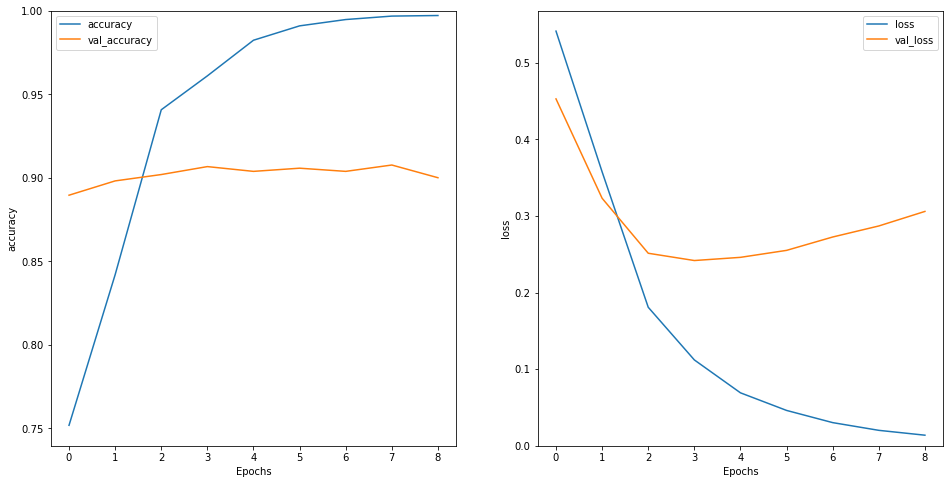

In [38]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

#### Com stemming

In [ ]:
# model_CNN_1 = tf.keras.Sequential([
#     encoder_1,
#     tf.keras.layers.Embedding(
#         input_dim=len(encoder_1.get_vocabulary()),
#         output_dim=64,
#         # Use masking to handle the variable sequence lengths
#         mask_zero=True),
#     tf.keras.layers.Conv1D(filters=32, kernel_size=8, activation='relu'),
#     tf.keras.layers.MaxPool1D(pool_size=2),
#     #tf.keras.layers.Flatten(),    
#     tf.keras.layers.Dense(32, activation='relu'),
#     tf.keras.layers.GlobalMaxPool1D(),
#     tf.keras.layers.Dense(1, activation='sigmoid')
# ])

In [ ]:
import keras_tuner as kt
##Testando keras tuner

def model_builder_1(hp):

    hp_units = hp.Int('units', min_value=32, max_value=512, step=32)

    model_CNN_1 = tf.keras.Sequential([
    encoder_1,
    tf.keras.layers.Embedding(
        input_dim=len(encoder_1.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Conv1D(filters=32, kernel_size=8, activation='relu'),
    tf.keras.layers.MaxPool1D(pool_size=2),
    #tf.keras.layers.Flatten(),    
    tf.keras.layers.Dense(units=hp_units, activation='relu'), #>>>>>Hiperparametro
    tf.keras.layers.GlobalMaxPool1D(),
    tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model_CNN_1.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate), #>>>>>Hiperparametro
              metrics=['accuracy'])

    return model_CNN_1

In [ ]:
# Instantiate the tuner
tuner = kt.Hyperband(model_builder_1, # the hypermodel
                     objective='val_accuracy', # objective to optimize
max_epochs=10,
factor=3, # factor which you have seen above 
directory='tuner', # directory to save logs 
project_name='cnn_1')

In [ ]:
# hypertuning settings
tuner.search_space_summary() 


In [ ]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
# Perform hypertuning
tuner.search(X_train_join[1], y_train, epochs=10, validation_data = (X_valid_join[1], y_valid), callbacks=[stop_early])

In [ ]:
best_hp = tuner.get_best_hyperparameters()[0]

In [ ]:
# Build the model with the optimal hyperparameters
model_CNN_1 = tuner.hypermodel.build(best_hp)
model_CNN_1.summary()


In [ ]:
history = model_CNN_1.fit(X_train_join[1], y_train, epochs=10, validation_data = (X_valid_join[1], y_valid))

In [ ]:
# print(model_CNN_1.summary())

In [ ]:
# model_CNN_1.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
#               optimizer=tf.keras.optimizers.Adam(1e-4),
#               metrics=['accuracy'])

In [ ]:
# history = model_CNN_1.fit(X_train_join[1], y_train, epochs=20,
#                     batch_size = 32,
#                     validation_data= (X_valid_join[1], y_valid),
#                     validation_steps=3
#                     )

In [ ]:
#test_loss, test_acc = model_CNN_1.evaluate(X_test_join[1], y_test)
test_loss, test_acc = model_CNN_1.evaluate(X_test_join[1], y_test)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

In [ ]:
result = h_model.predict(X_test_join[1])
result = np.where(result > 0.5, 1, 0)
result

print(classification_report(y_test, result))


In [ ]:
confusion_matrix(y_test, result)

In [ ]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

### LSTM

In [ ]:
model_LSTM0 = tf.keras.Sequential([
    encoder_0,
    tf.keras.layers.Embedding(
        input_dim=len(encoder_0.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
model_LSTM0.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
print(model_LSTM0.summary())

#### Sem stemming

Treinando modelo

In [ ]:
history = model_LSTM0.fit(X_train_join[0], y_train, epochs=20,
                    batch_size = 32,
                    validation_data= (X_valid_join[0], y_valid),
                    validation_steps=30
                    )

Avaliando modelo

In [ ]:
test_loss, test_acc = model_LSTM0.evaluate(X_test_join[0], y_test)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

In [ ]:
result = model_LSTM0.predict(X_test_join[0])
result = np.where(result > 0.5, 1, 0)
result

print(classification_report(y_test, result))

In [ ]:
confusion_matrix(y_test, result)

In [ ]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

#### Com stemming

In [ ]:
model_LSTM1 = tf.keras.Sequential([
    encoder_1,
    tf.keras.layers.Embedding(
        input_dim=len(encoder_1.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
model_LSTM1.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

Treinando modelo

In [ ]:
history = model_LSTM1.fit(X_train_join[1], y_train, epochs=10,
                    batch_size = 32,
                    validation_data= (X_valid_join[1], y_valid),
                    validation_steps=30
                    )

Avaliando modelo

In [ ]:
test_loss, test_acc = model_LSTM1.evaluate(X_test_join[1], y_test)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

In [ ]:
result = model_LSTM1.predict(X_test_join[1])
result = np.where(result > 0.5, 1, 0)
result

print(classification_report(y_test, result))

In [ ]:
confusion_matrix(y_test, result)

In [ ]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

### BERT

In [14]:
from transformers import BertTokenizer

In [15]:
tokenizer = BertTokenizer.from_pretrained('neuralmind/bert-base-portuguese-cased', do_lower_case=True)

In [16]:
def convert_example_to_feature(review):
  return tokenizer.encode_plus(review,
                add_special_tokens = True, # add [CLS], [SEP]
                max_length = max_length, # max length of the text that can go to BERT
                pad_to_max_length = True, # add [PAD] tokens
                return_attention_mask = True, # add attention mask to not focus on pad tokens
              )

In [17]:
# can be up to 512 for BERT
max_length = 256
batch_size = 1

In [18]:
def map_example_to_dict(input_ids, attention_masks, token_type_ids, label):
  return {
      "input_ids": input_ids,
      "token_type_ids": token_type_ids,
      "attention_mask": attention_masks,
  }, label

In [19]:
def encode_examples(texts, labels, limit=-1):
  # prepare list, so that we can build up final TensorFlow dataset from slices.
  input_ids_list = []
  token_type_ids_list = []
  attention_mask_list = []
  label_list = []
  if (limit > 0):
      ds = ds.take(limit)
  # for review, label in tfds.as_numpy(ds):
  for text, label in zip(texts, labels):
    bert_input = convert_example_to_feature(text)
    input_ids_list.append(bert_input['input_ids'])
    token_type_ids_list.append(bert_input['token_type_ids'])
    attention_mask_list.append(bert_input['attention_mask'])
    label_list.append([label])
  return tf.data.Dataset.from_tensor_slices((input_ids_list, attention_mask_list, token_type_ids_list, label_list)).map(map_example_to_dict)

#### Sem stemming

In [20]:
# train dataset
ds_train_encoded_0 = encode_examples(X_train_join[0], y_train).shuffle(3).batch(batch_size)

# test dataset
ds_test_encoded_0 = encode_examples(X_test_join[0], y_test).batch(batch_size)

#validation dataset
ds_valid_encoded_0 = encode_examples(X_valid_join[0], y_valid).batch(batch_size)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
C:\Users\lucas\anaconda3\lib\site-packages\transformers\tokenization_utils_base.py:2226: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
from transformers import TFBertForSequenceClassification
import tensorflow as tf
# recommended learning rate for Adam 5e-5, 3e-5, 2e-5
learning_rate = 2e-5
# we will do just 1 epoch, though multiple epochs might be better as long as we will not overfit the model
number_of_epochs = 3
# model initialization
model_bert_0 = TFBertForSequenceClassification.from_pretrained('bert-base-portuguese-cased', from_pt = True)

In [ ]:
# choosing Adam optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, epsilon=1e-08)
# we do not have one-hot vectors, we can use sparce categorical cross entropy and accuracy
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
model_bert_0.compile(optimizer=optimizer, loss=loss, metrics=[metric])

In [ ]:
bert_history = model_bert_0.fit(ds_train_encoded_0, epochs=number_of_epochs, validation_data=ds_valid_encoded_0)

In [ ]:
tf_output = model_bert_0.predict(ds_test_encoded_0)[0]
tf_prediction = tf.nn.softmax(tf_output, axis=1)
labels = ['Negative','Positive'] #(0:negative, 1:positive)
label = tf.argmax(tf_prediction, axis=1)
label_pred = label.numpy()
print(label_pred)

In [ ]:
unique, counts = np.unique(label_pred, return_counts=True)
dict(zip(unique, counts))

In [ ]:
print(classification_report(y_test, label_pred))

In [ ]:
confusion_matrix(y_test, label_pred)

#### Com stemming

In [ ]:
# train dataset
ds_train_encoded_1 = encode_examples(X_train_join[1], y_train).shuffle(3).batch(batch_size)

# test dataset
ds_test_encoded_1 = encode_examples(X_test_join[1], y_test).batch(batch_size)

#validation dataset
ds_valid_encoded_1 = encode_examples(X_valid_join[1], y_valid).batch(batch_size)

In [ ]:
from transformers import TFBertForSequenceClassification
import tensorflow as tf
# recommended learning rate for Adam 5e-5, 3e-5, 2e-5
learning_rate = 2e-5
# we will do just 1 epoch, though multiple epochs might be better as long as we will not overfit the model
number_of_epochs = 3
# model initialization
model_bert_1 = TFBertForSequenceClassification.from_pretrained('bert-base-portuguese-cased', from_pt = True)

In [ ]:
# choosing Adam optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, epsilon=1e-08)
# we do not have one-hot vectors, we can use sparce categorical cross entropy and accuracy
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
model_bert_1.compile(optimizer=optimizer, loss=loss, metrics=[metric])

In [ ]:
bert_history = model_bert_1.fit(ds_train_encoded_1, epochs=number_of_epochs, validation_data=ds_valid_encoded_1)

In [ ]:
tf_output = model_bert_1.predict(ds_test_encoded_1)[0]
tf_prediction = tf.nn.softmax(tf_output, axis=1)
labels = ['Negative','Positive'] #(0:negative, 1:positive)
label = tf.argmax(tf_prediction, axis=1)
label_pred = label.numpy()
print(label_pred)

In [ ]:
unique, counts = np.unique(label_pred, return_counts=True)
dict(zip(unique, counts))

In [ ]:
print(classification_report(y_test, label_pred))

In [ ]:
confusion_matrix(y_test, label_pred)

## Clustering

In [ ]:
df_pp[["reviews", "reviews_pipeline_0", "class"]].head()

In [ ]:
df_cluster = df_pp[["reviews", "reviews_pipeline_0", "class"]]

X_join = df_cluster["reviews_pipeline_0"].apply(" ".join)
X_join = X_join.to_numpy()
#df_cluster["reviews_join"] = X_join

In [ ]:
vectorizer = CountVectorizer(analyzer = "word",   
                             tokenizer = None,    
                             preprocessor = None, 
                             stop_words = None,   
                             max_features = 2000) 

#List with BoWs (pipeline 0 and 1)
bow_vec = vectorizer.fit_transform(X_join)

In [ ]:
words = vectorizer.get_feature_names()
#words = vectorizer.get_feature_names_out()

#setup kmeans clustering
kmeans = KMeans(n_clusters = 2, random_state = 420)
#fit the data 
kmeans.fit(bow_vec)

In [ ]:
kmeans.cluster_centers_

https://towardsdatascience.com/k-means-clustering-chardonnay-reviews-using-scikit-learn-nltk-9df3c59527f3

In [ ]:
### Palavras mais comuns em cada cluster
common_words = kmeans.cluster_centers_.argsort()[:,-1:-11:-1]
for num, centroid in enumerate(common_words):
    print(str(num) + ' : ' + ', '.join(words[word] for word in centroid))

Usando distancia

In [ ]:
closest, _ = pairwise_distances_argmin_min(kmeans.cluster_centers_, csr_matrix.toarray(bow_vec))
closest

Usando vector quantization (https://stackoverflow.com/questions/21660937/get-nearest-point-to-centroid-scikit-learn)

In [ ]:
# centroids: N-dimensional array with your centroids
# points:    N-dimensional array with your data points
closest, distances = vq(kmeans.cluster_centers_, csr_matrix.toarray(bow_vec))
closest

https://stackoverflow.com/questions/39766593/get-element-closest-to-cluster-centroid

In [ ]:
from scipy.spatial import cKDTree

def find_k_closest(centroids, data, k=1, distance_norm=2):
    """
    Arguments:
    ----------
        centroids: (M, d) ndarray
            M - number of clusters
            d - number of data dimensions
        data: (N, d) ndarray
            N - number of data points
        k: int (default 1)
            nearest neighbour to get
        distance_norm: int (default 2)
            1: Hamming distance (x+y)
            2: Euclidean distance (sqrt(x^2 + y^2))
            np.inf: maximum distance in any dimension (max((x,y)))

    Returns:
    -------
        indices: (M,) ndarray
        values: (M, d) ndarray
    """

    kdtree = cKDTree(data)
    distances, indices = kdtree.query(centroids, k, p=distance_norm)
    if k > 1:
        indices = indices[:,-1]
    values = data[indices]
    return indices, values

indices, values = find_k_closest(kmeans.cluster_centers_, csr_matrix.toarray(bow_vec))

In [ ]:
indices

Achar os n mais proximos (https://stackoverflow.com/questions/26795535/output-50-samples-closest-to-each-cluster-center-using-scikit-learn-k-means-libr)

- n Reviews mais próximas do centróide da classe 0 (Ruim)

In [ ]:
n=3
d = kmeans.transform(csr_matrix.toarray(bow_vec))[:, 0] #distancia de cada ponto ao centroide 0
ind0 = np.argsort(d)[::][:n]
ind0
#csr_matrix.toarray(bow_vec)[ind]

In [ ]:
df_pp.iloc[3650]#["reviews"]

In [ ]:
df_pp.iloc[3650]["reviews"]

In [ ]:
df_pp.iloc[4823]#["reviews"]

In [ ]:
df_pp.iloc[4823]["reviews"]

- n Reviews mais próximas do centróide da classe 1 (Bom)

In [ ]:
n = 3
d = kmeans.transform(csr_matrix.toarray(bow_vec))[:, 1] #distancia de cada ponto ao centroide 1
ind1 = np.argsort(d)[::][:n]
ind1

In [ ]:
df_pp.iloc[3603]#["reviews"]

In [ ]:
df_pp.iloc[3217]#["reviews"]

In [ ]:
df_pp.iloc[3998]#["reviews"]

In [ ]:
#X_test["pred"] = result
#df_pred = pd.merge(X_test[["class", "pred"]], df_pp[["reviews", "stars", "dates"]], left_index=True, right_index=True)
#df_pred.to_csv("best_pred.csv", index=False)

def save_results(result, X_test, df_pp, dfname="best_pred.csv"):
    X_test["pred"] = result
    df_pred = pd.merge(X_test[["class", "pred"]], df_pp[["reviews", "stars", "dates"]], left_index=True, right_index=True)
    df_pred.to_csv(dfname, index=False)

save_results(result, X_test, df_pp)

In [59]:
pd.read_csv("best_pred.csv")

,class,pred,reviews,stars,dates
0,1,1,Melhor compra que já fiz.Entrega super rápid...,5,2021-12-04
1,1,1,"Produto de primeira qualidade, fácil instala...",5,2021-11-29
2,1,1,Gostei muito do produto. Tem diversos app qu...,5,2021-06-28
3,1,1,"Não sei o que aconteceu, pode ter caido o co...",5,2021-08-27
4,1,1,O que mais gostei foi que ligando ele a TV l...,5,2021-12-10
...,...,...,...,...,...
1496,1,1,"Perfeito, o unico problema e que a minha tv ...",5,2022-01-05
1497,1,1,"Aparelho bem veloz e intuitivo, falta alguns...",5,2021-06-01
1498,0,1,"Não funciona em qualquer televisão, me senti...",2,2021-10-23
1499,1,1,"Ótimo aparelho!Fácil de manusear, instalar. ...",5,2021-12-16
